In [126]:
import pandas as pd
import ast
import nltk
import re
from string import punctuation
import matplotlib.pyplot as plt
import numpy as np
import gensim
import json
import pickle
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import string

# Twitter on Trump
The following sections go through steps to take a look at the topics surrounding the tweets targeting Trump and the users who sent them.

## Sentiment by Platform

An initial question that was being explored was what is the overall sentiment of the tweets to Trump and how do these differ between platforms? To do so the 'source' column is converted into one of three keywords in the Tweets_Clean notebook. Each sample is then looked at for its source and sentiment type.

In [113]:
tweets = pd.read_csv('tweets_at_trump_41.csv')
tweets = tweets[tweets['state'] != "marietta beneficial association"]
tweets.reset_index(drop=True, inplace=True)

for i in range(len(tweets['state'])):
    if tweets['state'][i] == 'washington':
        tweets['state'][i] = 'wa'

/Users/Nima/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


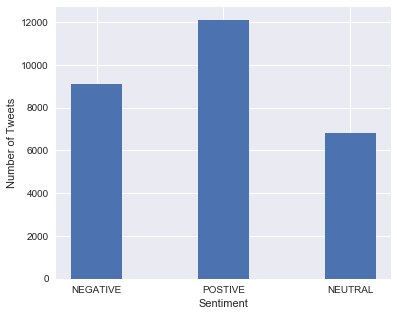

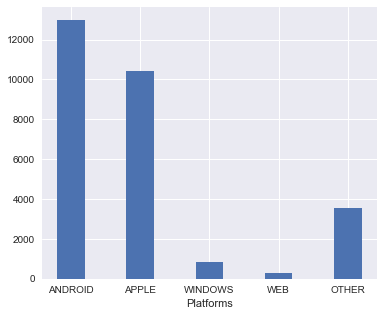

In [114]:
# Count number of neutral, negative, and positive sentiment tweets
neutral = 0
neg = 0
pos = 0

for t in tweets['sentiment_type']:
    if t == 'NEUTRAL': 
        neutral += 1
    elif t == 'NEGATIVE':
        neg += 1
    else:
        pos += 1

# Count number of tweets from each platform
droid = 0
apple = 0
windows = 0
web = 0
other = 0
for s in tweets['source']:
    if s == 'android':
        droid += 1
    elif s == 'iphone' or s == 'ipad' or s == 'macos':
        apple += 1
    elif s == 'web':
        web += 1
    elif s == 'windows':
        windows += 1
    else:
        other += 1

# Convert counts to dictionary to plot bar graphs
source_counts = {'ANDROID': droid, 'APPLE': apple, 'WINDOWS': windows, 'WEB': web, 'OTHER': other}
type_counts = {'NEGATIVE': neg, 'POSTIVE': pos, 'NEUTRAL': neutral}

plt.figure(figsize=(6,5))
plt.ylabel('Number of Tweets')
plt.xlabel('Sentiment')
plt.bar(list(type_counts.keys()), list(type_counts.values()), width=0.4)

plt.figure(figsize=(6,5))
plt.xlabel('Platforms')
plt.bar(list(source_counts.keys()), list(source_counts.values()), width=0.4)
plt.show()

### Take sentiment with a grain of salt...
The results were suprising, but the issue is sentiment does not account for things such as sarcasm, context, etc. This could be why we are seeing more positive sentiment. So the sentiment per tweet does not best reflect the overall attitude of Twitter towards Trump. A better was to do this is to look at the main topics of the tweets instead. By using topic modeling, we can get a better sense of what the overall topics are that are being discussed.

## Topic Modeling of Tweets by State

What are the main topics in the tweets targeted at Donald Trump? Is there a difference in topics between states? To answer these questions we need to group the tweets by location and then look at each group of tweets separately. The general idea behind using LDA for topic modeling is that each tweet will be treated as a document, and each document will be a distribution of topics where each topic is a distribution of words. We want to know what are the top words contributing to each topic for each state.

### Group the tweets by location

The tweets are grouped by state and then each group's corresponding dataframe is added to a list. This list will be used to build a topic model for each group of tweets by using LDA to extract topics for each state individually. Unfortunately, the states listed for user accounts are inputted by the user so not all of them are actual states in the United States. Some users have organization names and jokes as their location, so they are filtered out to keep the locations that are actual states in America.

In [115]:
# this is the list of actual states in the dataframe
states_list = ['ky', 'ca', 'nj', 'tx', 'tn', 'ny', 'dc', 'nm', 'il', 'nv', 'az',
               'fl', 'va', 'oh', 'wa', 'co', 'mi', 'ut', 'al', 'pa', 'in', 'ma',
               'ne', 'or', 'wi', 'ms', 'id', 'nh', 'vt', 'la', 'md', 'ct', 'hi',
               'nc', 'ok','mn', 'ar', 'ia', 'mo', 'me', 'ga', 'ak', 'sd', 'ri', 
               'de', 'sc']

# filter the dataframe to contain tweets and users only from states_list
tweets = tweets[tweets['state'].isin(states_list)]
states = tweets['state'].unique()
tweets_by_state = []

# group the tweets by state
df_by_place = tweets.groupby('state')

# get each dataframe of tweets by its state and add it to the list tweets_by_state
for i in range(len(states)):
    tweets_by_state.append(df_by_place.get_group(states[i]))

### Parameter Tuning for State Topic Models

The tweets are then cleaned and removed of stop words. Each tweet is then converted to a bigram. The tokenized tweets are used as a dictionary and as a corpus for the LDA model implemented by Gensim. The function below takes each group of tweets and does a parameter search for a topic model. The parameter being searched is the number of topics. For each parameter value the function fits an LDA model to the tweets and then measures the coherence of the model. Each parameter and the corresponding coherence is kept track of. Due to the time it takes to fit each model the parameter values tried are 1, 2, 3, 4, 5, 6, 7.

In [116]:
from gensim.models.coherencemodel import CoherenceModel
from collections import Counter
from nltk.util import everygrams
other_words = ['you', 'i']

# This function will be used on each dataframe in tweets_by_state 
def search_params(tweets, num_topics):
    
    coherences = []
    topic_num = []
    en_stop = set(nltk.corpus.stopwords.words('english'))
    tok_twts = []
    n = 2  # for converting the tweets to bigrams
    
    
    # Clean the tweets and tokenize
    for tweet in tweets['tweet']:
        tokens = nltk.tokenize.word_tokenize(tweet)
        tokens = [token.lower() for token in tokens]
        tokens = [token for token in tokens if token not in en_stop]
        tokens = [token for token in tokens if token not in other_words]
        bigrams = zip(*[tokens[i:] for i in range(n)])
        tokens = [" ".join(bigram) for bigram in bigrams]
        tok_twts.append(tokens)
    
    # create dictionary and corpus for tweets
    # this will be used each LDA model
    dictionary = gensim.corpora.Dictionary(tok_twts)
    corpus = [dictionary.doc2bow(tweet) for tweet in tok_twts]
    
    # try 1 to num_topics sizes for number of topics
    # train each model for 50 iterations and keep track of the coherence
    # for each model as well as its corresponding k (number of topics)
    for k in range(1, num_topics):
        ldamodel = gensim.models.ldamodel.LdaModel(corpus, 
                                                   iterations=50, 
                                                   num_topics=k, 
                                                   id2word=dictionary, 
                                                   passes=20)
        
    
        cm = CoherenceModel(model=ldamodel, corpus=corpus, coherence='u_mass')
        coherences.append(cm.get_coherence())
        topic_num.append(k)
        
    return coherences, topic_num, dictionary, corpus

In [117]:
# This will find the best parameters for the LDA for a set of Tweets
def find_best(tweets, num_topics):
    
    # Run parameter search on a group of tweets
    c, k, dictionary, corpus = search_params(tweets, num_topics)
    
    # The coherence list and topic numbers list correspond to eachother by position.
    # By getting the position with the best coherence we can index into k for the best
    # parameter.
    best_pos = np.argmin(c)
    best_k = k[best_pos]
    best_c = c[best_pos]
    
    return best_k, best_c, c, k, dictionary, corpus

In [118]:
# This uses the best parameters to fit LDA
def build_best_model(k_topics, d, corpus):
    ldamodel = gensim.models.ldamodel.LdaModel(corpus, 
                                               iterations=25, 
                                               num_topics=k_topics, 
                                               id2word=d, 
                                               passes=20
                                              )
    
    cm = CoherenceModel(model=ldamodel, corpus=corpus, coherence='u_mass')
    c = cm.get_coherence()
    return ldamodel, c

The cell below keeps a list of topic models per state. Each group of tweets is found an optimal topic model and the topics are extracted to see what are the most talked about things in each state. Each member of the model_by_state list has the best parameter value, the model, the best coherence, and the state name.

In [119]:
model_by_state = []

# Build LDA for each group of tweets
for i in range(len(tweets_by_state)):
    
    # Get best topic numbers for each model
    best_k, best_c, c_list, k_list, dictionary, corpus = find_best(tweets_by_state[i], 7)
    
    # Run model with that number of topics
    model, coherence = build_best_model(best_k, dictionary, corpus)
    
    # Keep track of city, state for each model (This is stored in places list)
    model_by_state.append( (best_k, model, coherence, states[i]) )

In [120]:
k = 0
model = 1
coherence = 2
state = 3

# Get the topics from each model for each state
for i in range(len(model_by_state)):
    print('STATE: ', model_by_state[i][state])
    print(f'  TOP {model_by_state[i][k]} TOPICS: ', model_by_state[i][model].print_topics(model_by_state[i][k], 3))
    print(f'  MODEL COHERENCE: ', model_by_state[i][coherence])

STATE:  ky
  TOP 2 TOPICS:  [(0, '0.013*"save home" + 0.012*"help save" + 0.010*"please help"'), (1, '0.012*"save home" + 0.009*"help save" + 0.008*"mr president"')]
  MODEL COHERENCE:  -16.26141684665179
STATE:  ca
  TOP 2 TOPICS:  [(0, '0.001*"shut bag" + 0.001*"bag wind" + 0.001*"would love"'), (1, '0.005*"mr trump" + 0.001*"donald trump" + 0.001*"birth certificate"')]
  MODEL COHERENCE:  -20.466758570353555
STATE:  nj
  TOP 1 TOPICS:  [(0, '0.003*"mr trump" + 0.001*"gop e" + 0.001*"u need"')]
  MODEL COHERENCE:  -22.09170985809311
STATE:  tx
  TOP 6 TOPICS:  [(0, '0.019*"donald trump" + 0.017*"president donald" + 0.014*"next president"'), (1, '0.008*"mr trump" + 0.005*"donald trump" + 0.002*"good luck"'), (2, '0.003*"mr trump" + 0.003*"donald trump" + 0.001*"president trump"'), (3, '0.003*"dirtydon dirtydon" + 0.002*"fake news" + 0.002*"president trump"'), (4, '0.003*"mr trump" + 0.001*"health care" + 0.001*"president trump"'), (5, '0.003*"donald trump" + 0.003*"president trump" + 

### Topic Modeling Results
The ideal result from the topic modeling would be that we could see what each state was mainly talking about when tweeting about Donald Trump. The actual results are not ideal though. For each state we can look at the topics and the top 3 key words contributing to each topic. Some states are a little more obvious as to what the topics are. For example, looking at "tn" (Tennesee) we see "tax returns", "president maga", and "maga rt". "rt" typically stands for "re-tweet" in Twitter. It could be that users in Tenessee are more supportive of Trump due to these keywords being the most weighted in the overall composition of the topic. Another state that had some interesting results was "mi" (Michigan) where we see words like "foreign slave" being a top keyword for one topic but also seeing "lib goofs" for a separate topic. "lib" seems to stand for liberal, thus that topic may be against liberal agendas. A more obvious state was "in" (Indiana) where we see "lyin donnie" the top keyword for each topic among others such as "crooked donnie". Overall, this sample of tweets at Donald Trump can give some insight into which states' twitter users are more for or against Trump.

## Who are the users?

Another interesting portion of the data to explore are the users. What type of profiles do these tweets come from? What category/type of profile is tweeting more? We can do this with clustering algorithms. The following takes each user's twitter bio and attempts to cluster them to see how and if the users are grouped together.

The pulled tweets do not all come from a unique user. We have to get all unique bios and their IDs. 

In [70]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize.casual import TweetTokenizer
import ast
tweets.reset_index(drop=True, inplace=True)
users = tweets['user'].unique()
bios = []
uid = []

for i in range(len(users)):
    user_json = ast.literal_eval(users[i])
    if user_json['description'] == None: 
        continue
    bios.append(user_json['description'])
    uid.append(user_json['id'])

In [72]:
assert len(bios) == len(uid)

### Clean and convert the list of Twitter bios to a bag of words
Twitter bios can be kind of messy. The following functions clean them up by removing URLs, removing other Twitter handles, and converting to lower case. These functions are used specifically for the bag of words/vector representation for the user bios. The visualizations show the actual, raw bios.

In [124]:
# This function removes the links from the twitter bios and puts a tag in its place
# to show that a URL was here.
def remove_links(user_bio, sub=None):
    if sub == None:
        sub = '<-URL->' 
    else:
        sub
    
    # regular expression to detect links
    pattern = re.compile('(https?://)?(\w*[.]\w+)+([/?=&]+\w+)*')
    
    # return string with pattern being replaced by sub
    bios_no_links = re.sub(pattern, sub, user_bio)
    
    return bios_no_links

In [155]:
# This will be used to tokenize the twitter bios. The bios will
# be stripped of handles and converted to lower case.
def bio_tokenizer(twitter_bio, keep_case=False, shorten=True, remove_handles=False):
    tokenizer = TweetTokenizer(preserve_case=keep_case,
                               reduce_len=shorten,
                               strip_handles=remove_handles)
    
    # remove punctuation
    stop = set(nltk.corpus.stopwords.words('english'))
    punc = string.punctuation
    tokens = tokenizer.tokenize(twitter_bio)
    
    cleaned_tokens = []
    for token in tokens:
        word = ""
        for c in token:
            if token in stop:
                continue
            elif token in punc:
                continue
            else:
                word += c
            
        else:
            cleaned_tokens.append(word)
    
    
    return cleaned_tokens

### Term-Frequency Inverse Document Frequency (TFIDF) vectorizer to convert bios to sparse matrix with normalized features (bag of words)
TFIDF vectorizer is used to create sparse matrix containing all the information for the user bios. The features are all possible words and the values in the cells are the normalized frequency of the word in the corpus of tweets. TFIDF weights the word frequencies in such a way that the higher the score the more important the word is across documents (tweets), where words that occur more frequently such as "of", "the", "is" are weighted much less while other words that could be more rare are weighted as much more important. 

In [156]:
num_features = len(set(uid)) // 100
en_stop = set(nltk.corpus.stopwords.words('english'))

# The functions are used as parameters for the TFID vectorizer. The vectorizer will 
# be used to convert the list of bios into a matrix with each row representing a bio
# (a bag of words representation of the entire corpus)
vec = TfidfVectorizer(preprocessor=remove_links,
                      tokenizer=bio_tokenizer,
                      stop_words=en_stop,
                      max_features=num_features
                     )

In [157]:
# We convert the bios into a bag of words here.
bio_matrix = vec.fit_transform(bios)

/Users/Nima/anaconda/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


### Clustering the data with K-Means
The matrix of bios is fed into the KMeans algorithm after we do a grid search for the optimal number of clusters. This optimal number is used for the number of clusters in the model that is trained on the data.

In [158]:
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV

# KMeans model optimization
kmeans = KMeans()
params = {'n_clusters': [8, 10, 20, 50, 100, 150, 200],
          'algorithm': ['auto']}
grid_search = GridSearchCV(kmeans, params)

In [159]:
grid_search.fit(bio_matrix)

GridSearchCV(cv=None, error_score='raise',
       estimator=KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=8, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_clusters': [8, 10, 20, 50, 100, 150, 200], 'algorithm': ['auto']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [160]:
# Fit model with best hyperparameters
k = grid_search.best_params_['n_clusters']
model = KMeans(n_clusters=k, algorithm='auto')
model.fit(bio_matrix)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=200, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

### Looking at label population sizes and visualizing data
After training the model on the data we can plot out the population sizes per label. In this case the most optimal number of clusters is 200 and we can see higher population sizes for certain labels in the bar plot below, particularly label 0 seems to have a higher density. Higher values were searched over for number of clusters, but this particular cluster's density stayed constant over all values. We can further visualize these clusters by using t-SNE.

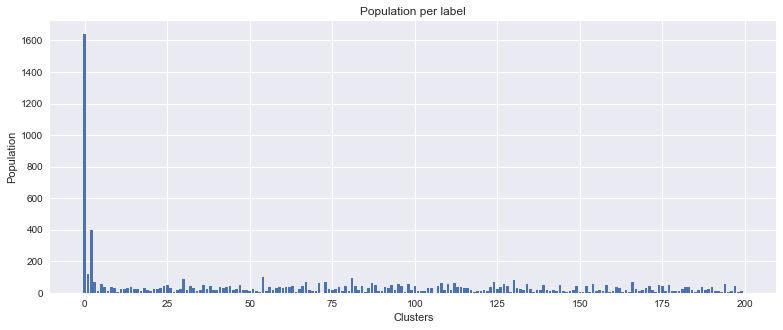

In [161]:
plt.figure(figsize=(13,5))
plt.xlabel('Clusters')
plt.ylabel('Population')
plt.title('Population per label')
plt.bar(range(len(set(model.labels_))), np.bincount(model.labels_))
plt.show()

In [167]:
from sklearn.manifold import TSNE
import seaborn as sns
tsne = TSNE(n_components=2,
            random_state=42)
bio_matrix_2d = tsne.fit_transform(bio_matrix.todense())

In [178]:
# Used the following link as a source of help
# https://twitterdev.github.io/do_more_with_twitter_data/clustering-users.html

labels = set(model.labels_)
num_labels = len(labels)

# set color of each label
cluster_colors = sns.color_palette('husl', num_labels).as_hex()

# dictionary for mapping each label to its color
color_table = {l : c for c,l in zip(cluster_colors, labels)}

# define new dataframe to use as plot for t-SNE
tsne_dict = {'id': uid, 
             'bio': bios, 
             'class': model.labels_,
             'x': bio_matrix_2d[:,0],
             'y': bio_matrix_2d[:,1],
             'color': list(map(lambda c: color_table[c], model.labels_))
            }

tsne_df = pd.DataFrame(tsne_dict)

In [182]:
# Used the following link as help for plotting the figure below
# https://twitterdev.github.io/do_more_with_twitter_data/clustering-users.html
width = 800
height = 700
plot_tools = ('pan, box_zoom, reset')

# Use this to show bios when hovering over a point in the plot
tool_tips = """<div style="width: 400px;">@bio : @class</div>"""

# Plot t-SNE. Provides a tool for seeing each point's bio.
data = ColumnDataSource(tsne_df)

tsne_cluster_plot = figure(title='t-SNE User Bios',
                           plot_width=width,
                           plot_height=height,
                           tools=plot_tools)

tsne_cluster_plot.add_tools(HoverTool(tooltips=tool_tips))

tsne_cluster_plot.circle('x',
                         'y',
                         source=data,
                         color='color',
                         line_alpha=0.2,
                         fill_alpha=0.1,
                         size=5,
                         hover_line_color='black')

tsne_cluster_plot.title.text_font_size = '12pt'
tsne_cluster_plot.xaxis.visible = False
tsne_cluster_plot.yaxis.visible = False
tsne_cluster_plot.grid.grid_line_color = None
tsne_cluster_plot.outline_line_color = None

In [183]:
from bokeh.plotting import figure, ColumnDataSource, show, output_notebook; output_notebook()
from bokeh.models import HoverTool

show(tsne_cluster_plot)

Loading BokehJS ...

## Clustering/t-SNE Results

Under a 2-dimensional t-SNE we see that one cluster does exist. Under label 0 we see a cluster of a variety of twitter bios that seem to be more personal twitter accounts. Under label 2 seems to be also a variety of bios but shorter in length. Overall the users seem to be all over the place for this sample and it is difficult to make any conclusions about the "type" of user that could send tweets to Trump. Everyone seems to have something to say.

## In Conclusion...
The results here provide a little insight into users who tweet about Trump. The biggest issue is the relatively small sample size; the original data pulled contained 40k tweets and after cleaning the tweets resulted in only about 27k tweets distributed over 10k users. This sample size may not be sufficient to get any real insight, especially when doing clustering. The other thing to mention is how the bag of words approach for the clustering does not take into consideration word positioning and simply taking into account word frequencies may not be enough to get a sense of who the users are when looking at their twitter bios. The topic modeling was more promising as to seeing how users from specific states feel towards Trump, but many state models did not find good keywords for the topics so it becomes difficult to determine the mindset in those places. With more samples distributed more evenly across each state could result in more promising and interpretable topics. The other thing to consider is that not everyone uses Twitter so obtaining a good idea of how people feel towards Trump is difficult. The older generations most likely are not using social media as heavily as the younger ones, and some states are not as full of "tech" users like California. It would be wise, and interesting, to see if social media data and other data that could capture people's opinions on Trump could be combined to obtain a better idea of what topics people are bringing up about the current "president".